## Import libraries

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Functions

## Combine patient data

In [197]:
results = pd.read_csv('results.csv')
results_nollm = results[results['Approach']=='nollm']
results_pixtral = results[results['Approach']=='pixtral-large-latest']
results_nollm = results_nollm.groupby(['Patient', 'Day'])['RMSE'].mean().reset_index()
results_pixtral = results_pixtral.groupby(['Patient', 'Day'])['RMSE'].mean().reset_index()
results_nollm['Difference'] = results_pixtral['RMSE'] - results_nollm['RMSE']
results = results_nollm[[ 'RMSE','Patient', 'Day', 'Difference']]

In [198]:
dataset = pd.read_csv("datasets/pixtral-large-latest_6.csv")
dataset['Day'] = pd.to_datetime(dataset['datetime']).dt.day

In [199]:
def calculate_glucose_metrics(group):
    metrics = {}
    glucose = group['glucose'].values
    
    # Basic statistics
    metrics['mean'] = group['glucose'].mean()
    metrics['std'] = group['glucose'].std()
    metrics['min'] = group['glucose'].min()
    metrics['max'] = group['glucose'].max()
    metrics['median'] = group['glucose'].median()
    metrics['range'] = metrics['max'] - metrics['min']
    
    # Glucose variability metrics
    metrics['num_glucose_readings'] = len(glucose)
    # Glucose excursions
    if len(glucose) > 1:
        diffs = np.abs(np.diff(glucose))
        metrics['mean_abs_change'] = np.mean(diffs)
        metrics['max_abs_change'] = np.max(diffs) if len(diffs) > 0 else 0
    else:
        metrics['mean_abs_change'] = 0
        metrics['max_abs_change'] = 0
    
    return pd.Series(metrics)

# Apply function to get all glucose metrics
glucose_stats = dataset.groupby(['patient', 'Day']).apply(calculate_glucose_metrics).reset_index()

# Convert 'Patient' column in results to match glucose_stats
results['Patient'] = results['Patient'].astype(int)

# Merge all glucose metrics with results dataframe in one step
results = pd.merge(
    results,
    glucose_stats,
    left_on=['Patient', 'Day'],
    right_on=['patient', 'Day'],
    how='left'
).drop(columns=['patient'])  # Remove duplicate patient column after merge

# Display to verify
print(f"Number of glucose metrics added: {len(glucose_stats.columns) - 2}")  # -2 for patient and Day
print("Columns in results:", results.columns.tolist())

Number of glucose metrics added: 9
Columns in results: ['RMSE', 'Patient', 'Day', 'Difference', 'mean', 'std', 'min', 'max', 'median', 'range', 'num_glucose_readings', 'mean_abs_change', 'max_abs_change']


/var/folders/tp/s93g_ywj25q87c9hgdw53dtm0000gn/T/ipykernel_82815/3937533894.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  glucose_stats = dataset.groupby(['patient', 'Day']).apply(calculate_glucose_metrics).reset_index()


In [200]:
meal_counts_data = []
patients = ['001', '002', '004', '006', '007', '008']
for patient in patients:
    # Load food data
    food_file = f"food_data/pixtral-large-latest/{patient}.csv"
    food_data = pd.read_csv(food_file)
    food_data['datetime'] = pd.to_datetime(food_data['datetime'], format='%Y:%m:%d %H:%M:%S')
    food_data['Day'] = food_data['datetime'].dt.day
    
    # Count meals per day for this patient
    daily_counts = food_data.groupby('Day').size().reset_index(name='num_meals')
    daily_counts['Patient'] = int(patient)
    meal_counts_data.append(daily_counts)


all_meal_counts = pd.concat(meal_counts_data)

# Convert Patient column type for proper merging
all_meal_counts['Patient'] = all_meal_counts['Patient'].astype(int)
results['Patient'] = results['Patient'].astype(int)

# Merge meal counts with results
results = results.merge(all_meal_counts[['Patient', 'Day', 'num_meals']], 
                        on=['Patient', 'Day'], how='left')

# Fill missing values if any - fixing the FutureWarning
results = results.copy()  # Create a copy to avoid chained assignment
results['num_meals'] = results['num_meals'].fillna(0)  # Use assignment instead of inplace

# Add time-related meal features
meal_timing_data = []
for patient in patients:
    # Load food data
    food_file = f"food_data/pixtral-large-latest/{patient}.csv"
    food_data = pd.read_csv(food_file)
    food_data['datetime'] = pd.to_datetime(food_data['datetime'], format='%Y:%m:%d %H:%M:%S')
    food_data['Day'] = food_data['datetime'].dt.day
    food_data['time_of_day'] = food_data['datetime'].dt.hour + food_data['datetime'].dt.minute/60
    
    # Group by day and calculate meal timing metrics
    daily_timing = food_data.groupby('Day').agg({
        'time_of_day': ['min', 'max', 'mean']
    }).reset_index()
    
    # Flatten the multi-index columns
    daily_timing.columns = ['Day', 'first_meal_time', 'last_meal_time', 'avg_meal_time']
    daily_timing['meal_window_hours'] = daily_timing['last_meal_time'] - daily_timing['first_meal_time']
    daily_timing['Patient'] = int(patient)
    
    meal_timing_data.append(daily_timing)

all_meal_timing = pd.concat(meal_timing_data)

# Convert Patient column type for proper merging
all_meal_timing['Patient'] = all_meal_timing['Patient'].astype(int)

# Merge meal timing with results
results = results.merge(all_meal_timing[['Patient', 'Day', 'first_meal_time', 
                                         'last_meal_time', 'avg_meal_time', 
                                         'meal_window_hours']], 
                        on=['Patient', 'Day'], how='left')

In [201]:
# Calculate daily macronutrient statistics
macronutrient_stats = []
patients = ['001', '002', '004', '006', '007', '008']

for patient in patients:
    # Load food data
    food_file = f"food_data/pixtral-large-latest/{patient}.csv"
    food_data = pd.read_csv(food_file)
    food_data['datetime'] = pd.to_datetime(food_data['datetime'], format='%Y:%m:%d %H:%M:%S')
    food_data['Day'] = food_data['datetime'].dt.day
    
    # Calculate daily macronutrient statistics
    daily_macros = food_data.groupby('Day').agg({
        'simple_sugars': ['sum', 'mean', 'std'],
        'complex_sugars': ['sum', 'mean', 'std'],
        'proteins': ['sum', 'mean', 'std'],
        'fats': ['sum', 'mean', 'std'],
        'dietary_fibers': ['sum', 'mean', 'std']
    }).reset_index()
    
    # Flatten the multi-index columns
    daily_macros.columns = ['_'.join(col).strip('_') if col[1] != '' else col[0] 
                            for col in daily_macros.columns.values]
    
    # Add patient identifier
    daily_macros['Patient'] = int(patient)
    
    macronutrient_stats.append(daily_macros)

# Combine all patients' macronutrient statistics
all_macronutrient_stats = pd.concat(macronutrient_stats)

# Merge with results dataframe
results = results.merge(all_macronutrient_stats, on=['Patient', 'Day'], how='left')

In [202]:

# Add insulin timing features
insulin_timing_data = []
for patient in patients:
    # Load insulin data
    insulin_file = f"diabetes_subset_pictures-glucose-food-insulin/{patient}/insulin.csv"
    insulin_data = pd.read_csv(insulin_file)
    
    # Create datetime from date and time
    insulin_data["datetime"] = pd.to_datetime(insulin_data["date"] + ' ' + insulin_data["time"])
    insulin_data['Day'] = insulin_data['datetime'].dt.day
    insulin_data['time_of_day'] = insulin_data['datetime'].dt.hour + insulin_data['datetime'].dt.minute/60
    
    # Calculate daily insulin statistics
    daily_insulin = insulin_data.groupby('Day').agg({
        'time_of_day': ['min', 'max', 'mean', 'count']
    }).reset_index()
    
    # Flatten the multi-index columns
    daily_insulin.columns = ['Day', 'insulin_first_time', 'insulin_last_time', 
                          'insulin_avg_time', 'insulin_count']
    daily_insulin['insulin_window_hours'] = daily_insulin['insulin_last_time'] - daily_insulin['insulin_first_time']
    daily_insulin['Patient'] = int(patient)
    
    insulin_timing_data.append(daily_insulin)

all_insulin_timing = pd.concat(insulin_timing_data, ignore_index=True)

# Convert Patient column type for proper merging
all_insulin_timing['Patient'] = all_insulin_timing['Patient'].astype(int)

# Merge insulin timing with results
results = results.merge(all_insulin_timing, 
                      on=['Patient', 'Day'], 
                      how='left')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


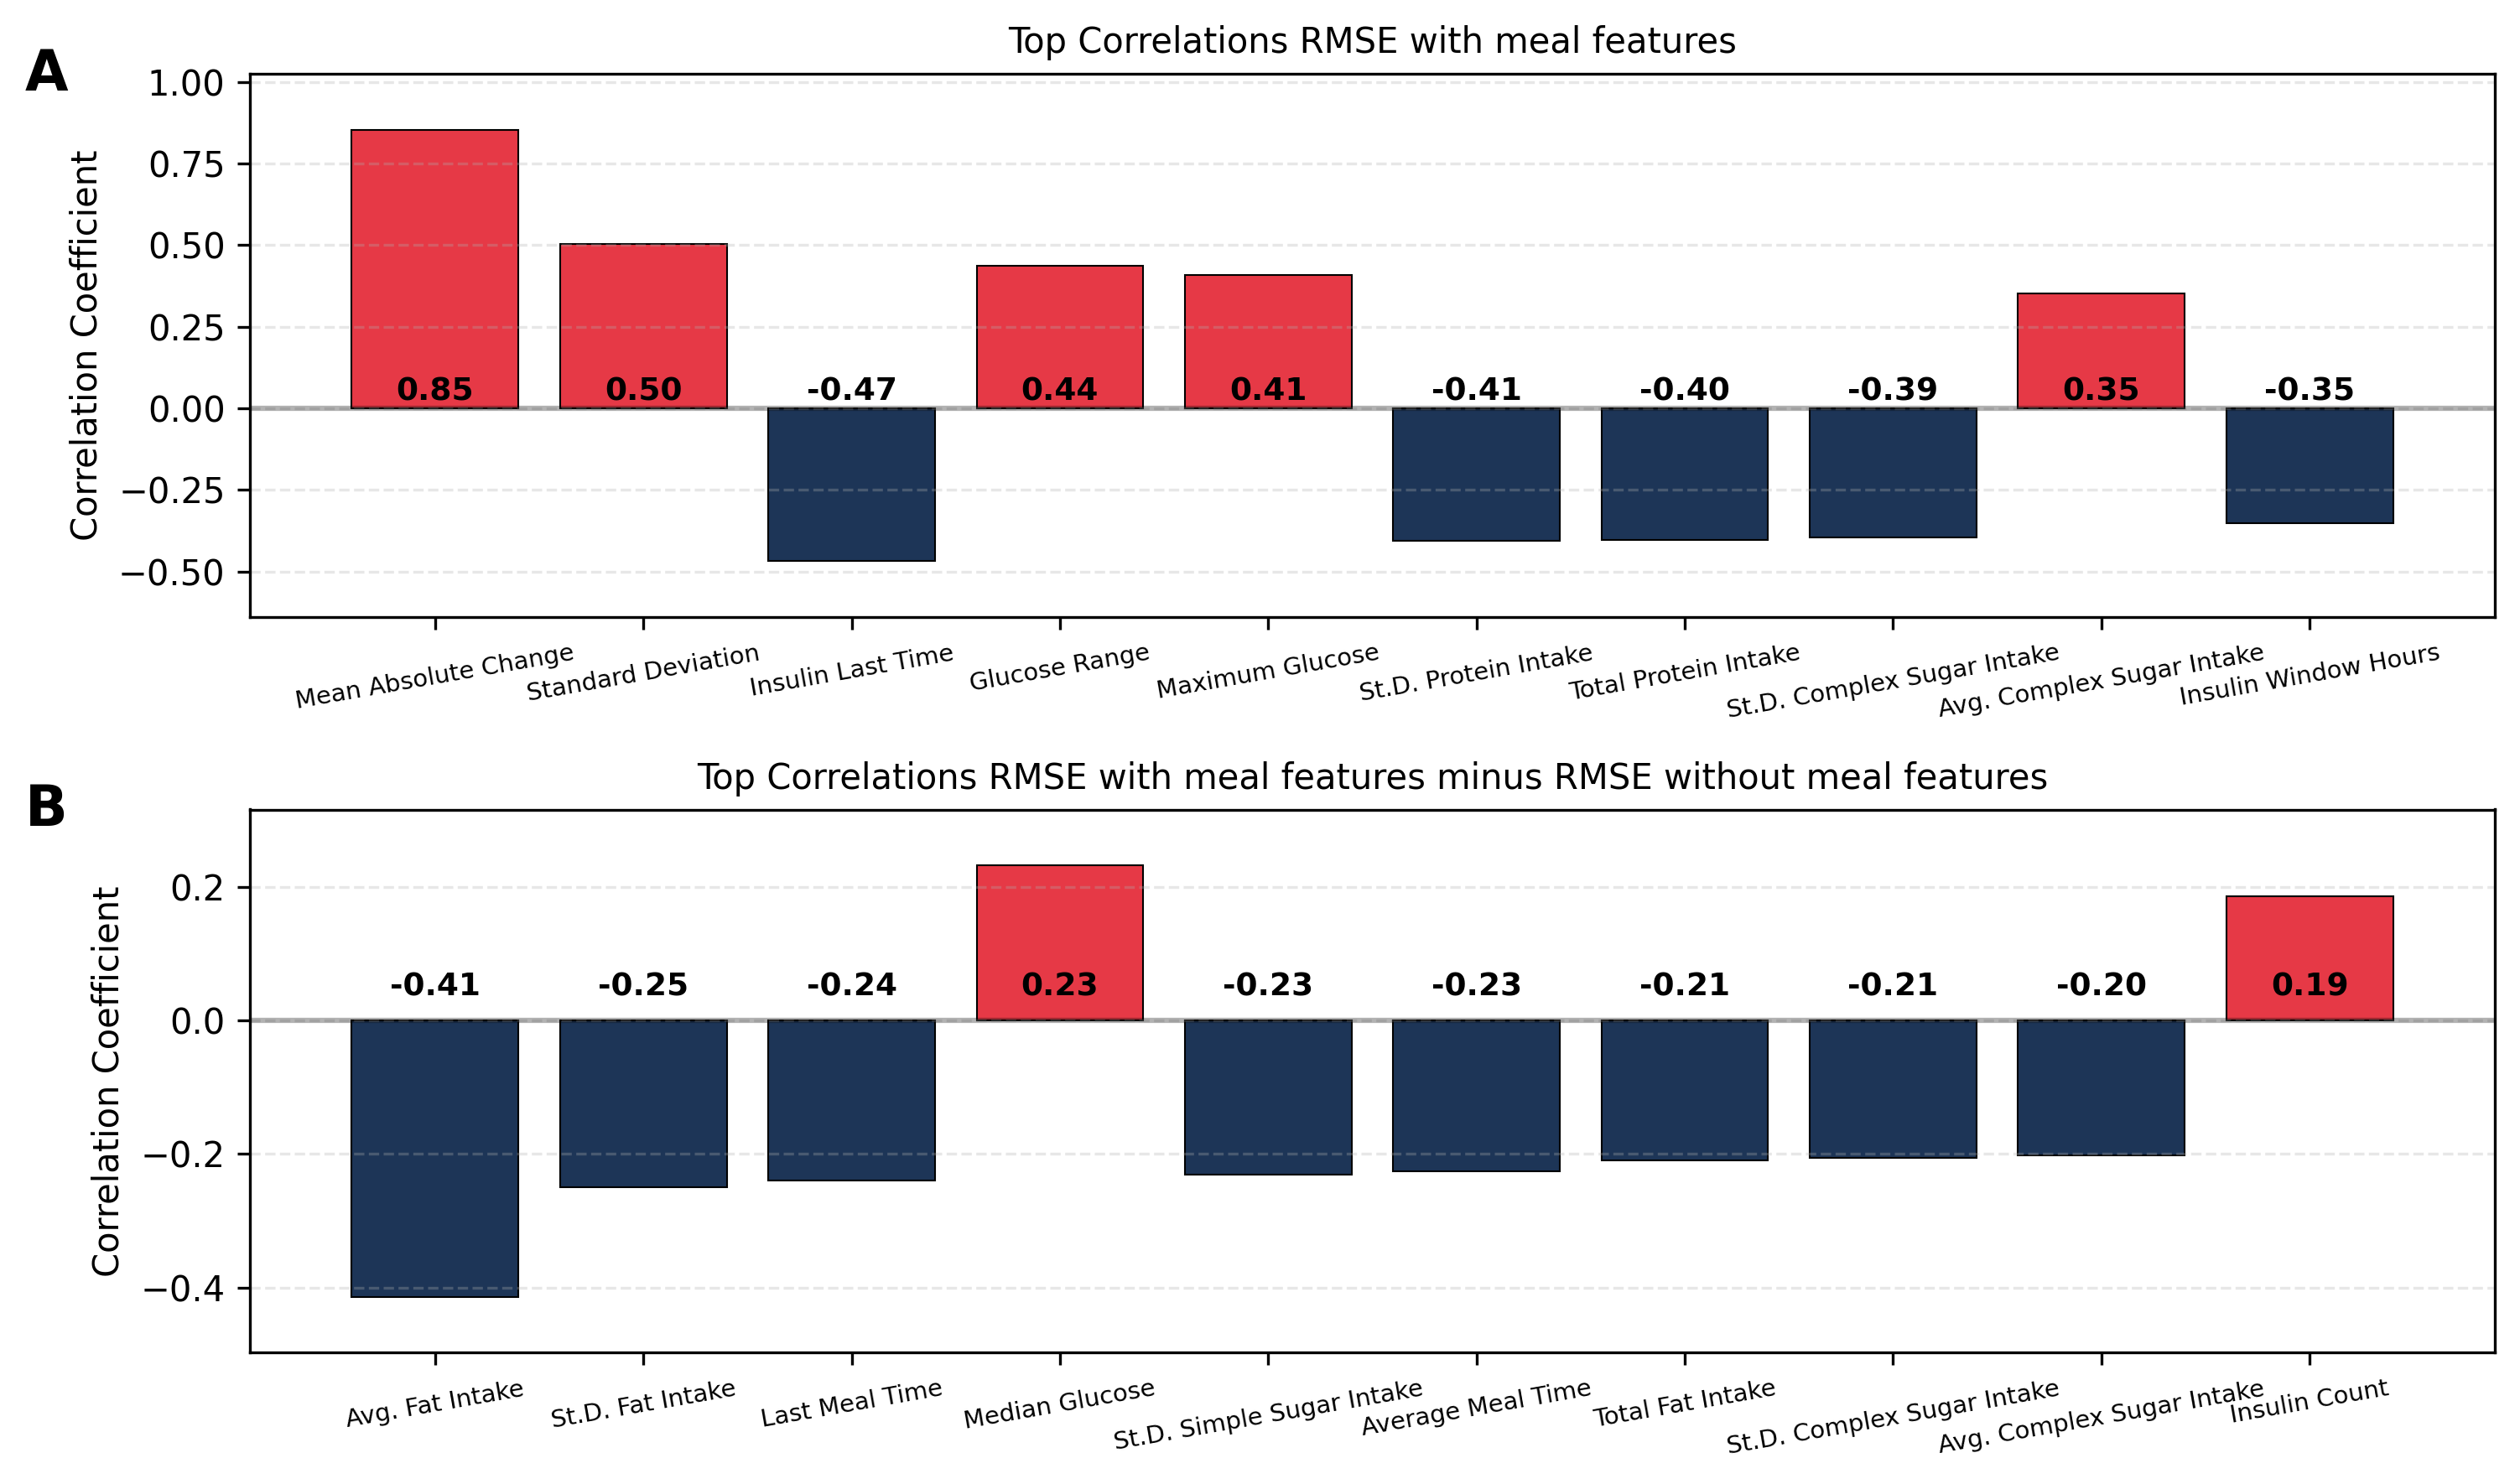

In [204]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6), dpi=300)  # Increased height for more space

# Common features to process both plots
features_to_plot = [
    ('RMSE', ['RMSE', 'Patient'], 'A', axes[0]),
    ('Difference', ['Difference', 'Patient', 'Day', 'RMSE'], 'B', axes[1])
]

better_labels = {
    'mean_abs_change': 'Mean Absolute Change',
    'std': 'Standard Deviation',
    'median': 'Median Glucose',
    'max': 'Maximum Glucose',
    'min': 'Minimum Glucose',
    'hbgi': 'High Blood Glucose Index',
    'max_abs_change': 'Maximum Absolute Change',
    'mean': 'Mean Glucose',
    'bgri': 'Blood Glucose Risk Index',
    'proteins': 'Protein Intake',
    'fats_mean': 'Avg. Fat Intake',
    'fats_std': 'St.D. Fat Intake',
    'fats_sum': 'Total Fat Intake',
    'proteins_mean': 'Avg. Protein Intake',
    'proteins_std': 'St.D. Protein Intake',
    'proteins_sum': 'Total Protein Intake',
    'complex_sugars_mean': 'Avg. Complex Sugar Intake',
    'complex_sugars_std': 'St.D. Complex Sugar Intake',
    'complex_sugars_sum': 'Total Complex Sugar Intake',
    'simple_sugars_mean': 'Avg. Simple Sugar Intake',
    'simple_sugars_std': 'St.D. Simple Sugar Intake',
    'simple_sugars_sum': 'Total Simple Sugar Intake',
    'dietary_fibers_mean': 'Avg. Dietary Fiber Intake',
    'dietary_fibers_std': 'St.D. Dietary Fiber Intake',
    'dietary_fibers_sum': 'Total Dietary Fiber Intake',
    'range': 'Glucose Range',
    'time_very_high_percent': 'Time Very High',
    'num_glucose_readings': 'Glucose Readings',
    'num_meals': 'Number of Meals',
    'meal_window_hours': 'Meal Window Hours',
    'insulin_window_hours': 'Insulin Window Hours',
    'insulin_avg_time': 'Insulin Average Time',
    'insulin_count': 'Insulin Count',
    'insulin_first_time': 'Insulin First Time',
    'insulin_last_time': 'Insulin Last Time',
    'avg_meal_time': 'Average Meal Time',
    'first_meal_time': 'First Meal Time',
    'last_meal_time': 'Last Meal Time',
}

for target_feature, features_to_drop, label, ax in features_to_plot:
    correlation_with_target = results.corr()[target_feature].drop(features_to_drop)
    
    # Get absolute values of correlations and find top 10
    top_correlations = correlation_with_target.abs().sort_values(ascending=False).head(10)
    top_features = top_correlations.index
    
    # Get the actual correlation values (with signs) for these features
    top_correlations_with_signs = correlation_with_target.loc[top_features]
    
    # Create proper labels list
    proper_labels = [better_labels.get(feat, feat) for feat in top_features]
    
    # Create a color palette (red for positive, blue for negative correlations)
    colors = ['#E63946' if c > 0 else '#1D3557' for c in top_correlations_with_signs]
    
    # Create the bar plot on the appropriate axis
    bars = ax.bar(range(len(proper_labels)), top_correlations_with_signs, color=colors, 
                edgecolor='black', linewidth=0.5)

    # Calculate y-limits to ensure we have space for our labels
    y_max = max(top_correlations_with_signs.max(), 0) 
    y_min = min(top_correlations_with_signs.min(), 0)
    
    # Add correlation values as text labels at fixed y=0.05 position
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., 
                0.05,  # Fixed y-position
                f'{height:.2f}',
                ha='center', va='center',
                color='black', fontweight='bold', fontsize=9)
    
    # Set the x-axis labels with improved positioning
    ax.set_xticks(range(len(proper_labels)))
    ax.set_xticklabels(proper_labels, rotation=10, ha='center', fontsize=7)
    
    # Add grid, label, and horizontal line at y=0
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    ax.set_ylabel('Correlation Coefficient', fontsize=10)
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Adjust y-limits appropriately for each subplot
    buffer = max(abs(y_max), abs(y_min)) * 0.2  # 20% buffer
    if label == 'A':  # First subplot
        ax.set_ylim(min(y_min - buffer, -0.1), max(y_max + buffer, 0.6))
    else:  # Second subplot (B) - correlations with Difference
        ax.set_ylim(min(y_min - buffer, -0.3), max(y_max + buffer, 0.3))  # More appropriate scale
    
    # Add plot label (A or B) in the upper left corner
    ax.text(-0.1, 1.05, label, transform=ax.transAxes, 
            fontsize=16, fontweight='bold', va='top')

# Add subplot titles
axes[0].set_title('Top Correlations RMSE with meal features', fontsize=10)
axes[1].set_title('Top Correlations RMSE with meal features minus RMSE without meal features', fontsize=10)

# Adjust layout with more bottom padding
plt.tight_layout()

plt.savefig('paper_images/results/combined_correlations.eps', dpi=300, bbox_inches='tight')
plt.show()

In [182]:
round(top_correlations_with_signs, 2)

fats_mean               0.41
last_meal_time          0.24
median                 -0.23
avg_meal_time           0.23
fats_sum                0.21
complex_sugars_mean     0.20
insulin_count          -0.19
num_glucose_readings   -0.17
mean                   -0.17
complex_sugars_sum      0.16
Name: Difference, dtype: float64